In [1]:
#SLAM(Simultaneous Localization and Mapping)ではエージェントが自分自身で地図を作らなければならない。
#また、その地図中での自分の姿勢を推定し続けなければいけない。つまり、推定対象は姿勢と地図である。
#ここでは、FastSLAMを実装する。

import sys  
sys.path.append('../scripts/')
from sample_mcl import *
from sample_kf import * 

In [2]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0)   #姿勢を元のクラスのposeに設定
        self.cov = None #変更 #共分散行列　初期ではNoneにしておく
      
    #描画する
    def draw(self, ax, elems): 
        if self.cov is None:   #共分散行列が設定されていないときは描画しない
            return
        
        ###推定位置に青い星を描く###
        #ランドマークの推定位置に青い星を描く
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        #ランドマークの誤差楕円を描く
        #sigma_ellipse　1つ目の引数が分布の中心、2つ目の引数が共分散行列、3つ目の引数の値を大きくすると楕円が大きくなる
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

In [3]:
#FastSLAM用のパーティクルを作る
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()    #パーティクルに地図を持たせる
        
        #地図に指定されたランドマークの個数だけ、パーティクルに持たせた地図にガウス分布
        #　のパラメータを表すEstimatedLandmarkクラスのオブジェクトを持たせる
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
    
    #あるランドマークを初めて観測した時
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        x, y, t = self.pose   #パーティクルの姿勢x、y、theta
        ell, phi = z   #観測値よりパーティクルから見たランドマークとの距離と角度を得る
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y   #ワールド座標系でのランドマークのx、y座標がmx、my
        
        #観測値をランドマークの位置の一次関数に近似する　線形化
        #センサ値をパーティクルの姿勢に基づいてワールド座標系でのランドマークの位置に変換したもの（mx、my）
        #　にランドマークの位置とそれとの差にHをかけた値をたして補正をかけることでランドマークの位置を計算する
        #Hの計算
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        
        #Qは尤度関数の共分散行列
        #距離と方角を独立と考えているため、対角行列になっている
        #ellは姿勢のx、y座標とランドマーク間の距離
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        #ランドマークの位置の共分散行列
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        #ランドマークの位置の分布の中心
        landmark.pos = np.array([mx, my]).T
    
    #あるランドマークの観測が2回目以降の時
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        x, y, _ = self.pose   #パーティクルの姿勢x、y
        mx, my =  landmark.pos   #ワールド座標系でのランドマークのx、y座標がmx、my
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
        estm_ell, _ = estm_z   #前の時刻に推定したランドマークの位置との距離
        if estm_ell < 0.01:   #推定位置が近すぎると計算がおかしくなるので回避
            return
        
        #観測値をランドマーク位置の一次関数に近似する　線形化
        #前の時刻に推定したランドマークの位置に観測したランドマークの位置と前の時刻に推定したランドマークの位置との差に
        #　行列Hをかけた値をたして補正をかけることでランドマークの位置を計算する
        #Hの計算
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        
        #Qは尤度関数の共分散行列
        #距離と方角を独立と考えているため、対角行列になっている
        #ellは姿勢のx、y座標とランドマーク間の距離
        #Qの計算
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        
        #カルマンゲインKの計算
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        #カルマンゲインの値によって補正する度合いが決まる
        #分布の中心
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        #共分散行列
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev): 
        #ランドマークごとにfor文をまわす
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            #初観測の時
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            #2回目以降の観測の時
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [4]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
                #nn は直進1[m]あたりに生じる直進方向のばらつきの標準偏差
                #no は回転1[rad]あたりに生じる直進方向のばらつきの標準偏差
                #on は直進1[m]あたりに生じる回転方向のばらつきの標準偏差
                #oo は回転1[rad]あたりに生じる回転方向のばらつきの標準偏差
                #ランドマークを観測した時の距離のばらつきの標準偏差が距離に比例した値である時の係数がdistance_dev_rate
                #ランドマークを観測した時の角度のばらつきの標準偏差がdirection_dev 
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):  
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev)
        self.set_ml()
        self.resampling()   #リサンプリング
        
    def draw(self, ax, elems):
        super().draw(ax, elems)   #パーティクルの姿勢を描画
        self.ml.map.draw(ax, elems)   #重みが最大のパーティクルが持つ地図を描画

<IPython.core.display.Javascript object>


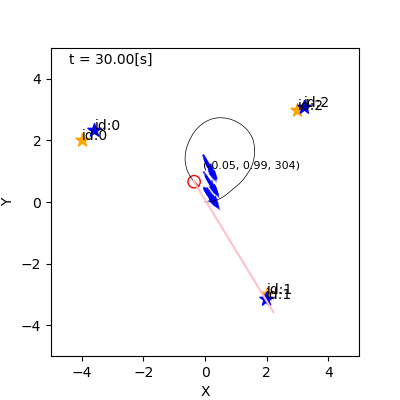

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1   #姿勢を更新する時間間隔であるΔtに相当するもの、また描画する時間間隔、0.1なら0.1秒ごとに描画する
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]   #ランドマークの座標
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    #初期位置
    init_pose = np.array([0,0,0]).T
    #パーティクルの数、パーティクルの初期位置、ランドマークの数を与える
    pf = FastSlam(100, init_pose, len(m.landmarks))
    #2つ目の引数が速度[m/s]、3つ目の引数が角速度[deg/s]
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    #ロボットの初期位置などを与える
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [6]:
a.pf.particles[10].map.landmarks[2].cov

In [7]:
math.sqrt(0.0025)

0.05